In the other notebook, for GW170814, the determination and subtraction of the event does not work for the event alone, nor for the double events. I think it could be due to the glitch in the signal. So, I try here in the case of GW150914, where the signal is better. The extraction will first be done for two masses and only one signal. Afterwards, we inject another signal and see if we can subtract on event and the the other. Here, we set-up the best way to subtract this. So, we use only one time and look at how it influences several parameters.

In [1]:
# Beautiful plots
%matplotlib inline 

#first we need to set bigger characters for the titles, labels and thicks.
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [2]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import matched_filter, highpass
import numpy as np
from pycbc.waveform import get_td_waveform, get_fd_waveform


In [3]:
merger = Merger("GW150914")
strain = merger.strain("H1")
strain = highpass(strain, 15)
strain = strain.crop(2,2)

strainF = strain.to_frequencyseries()

/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


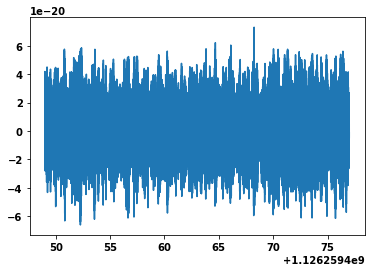

In [4]:
plt.plot(strain.sample_times, strain)

(1e-47, 1e-42)

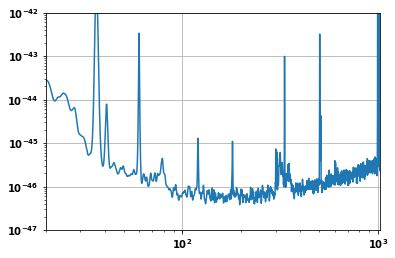

In [5]:
p = strain.psd(2)
p = interpolate(p, strainF.delta_f)
psd = inverse_spectrum_truncation(p, 2*strain.sample_rate, 
                                  low_frequency_cutoff = 15., 
                                  trunc_method = 'hann')

plt.loglog(psd.sample_frequencies, psd)
plt.grid()
plt.xlim(20,1024)
plt.ylim(1e-47, 1e-42)

In [6]:
import numpy as np

mass1 = np.arange(32.5, 40.4, 0.1)
mass2 = np.arange(29., 32.4, 0.1)

hmax = None
maxsnr, m1max, m2max, tmax = 0, 0, 0, 0

snrs = [[] for i in range(len(mass1))]
max_snrs = [[] for i in range(len(mass1))]
times_max = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = strainF.delta_f)
        hp.resize(len(strainF))
        
        snr = matched_filter(hp, strainF, psd = psd, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 10, merger.time + 10)
        snrs[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrs[i].append(snrp)
        time = snr.sample_times[idx]
        times_max[i].append(time)
        
        # Keep track of the max snr
        
        if snrp > maxsnr:
            tmax, hmax, m1max, m2max, maxsnr = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1max, m2max, tmax, maxsnr))

mass 1 1/79
Done
mass 1 2/79
Done
mass 1 3/79
Done
mass 1 4/79
Done
mass 1 5/79
Done
mass 1 6/79
Done
mass 1 7/79
Done
mass 1 8/79
Done
mass 1 9/79
Done
mass 1 10/79
Done
mass 1 11/79
Done
mass 1 12/79
Done
mass 1 13/79
Done
mass 1 14/79
Done
mass 1 15/79
Done
mass 1 16/79
Done
mass 1 17/79
Done
mass 1 18/79
Done
mass 1 19/79
Done
mass 1 20/79
Done
mass 1 21/79
Done
mass 1 22/79
Done
mass 1 23/79
Done
mass 1 24/79
Done
mass 1 25/79
Done
mass 1 26/79
Done
mass 1 27/79
Done
mass 1 28/79
Done
mass 1 29/79
Done
mass 1 30/79
Done
mass 1 31/79
Done
mass 1 32/79
Done
mass 1 33/79
Done
mass 1 34/79
Done
mass 1 35/79
Done
mass 1 36/79
Done
mass 1 37/79
Done
mass 1 38/79
Done
mass 1 39/79
Done
mass 1 40/79
Done
mass 1 41/79
Done
mass 1 42/79
Done
mass 1 43/79
Done
mass 1 44/79
Done
mass 1 45/79
Done
mass 1 46/79
Done
mass 1 47/79
Done
mass 1 48/79
Done
mass 1 49/79
Done
mass 1 50/79
Done
mass 1 51/79
Done
mass 1 52/79
Done
mass 1 53/79
Done
mass 1 54/79
Done
mass 1 55/79
Done
mass 1 56/79
Done
m

In [7]:
print(merger.time)

1126259462.4


subtraction of the signal from the data

In [8]:
sub = strainF - hmax

/home/justin/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


Text(0,0.5,'Normalized amplitude')

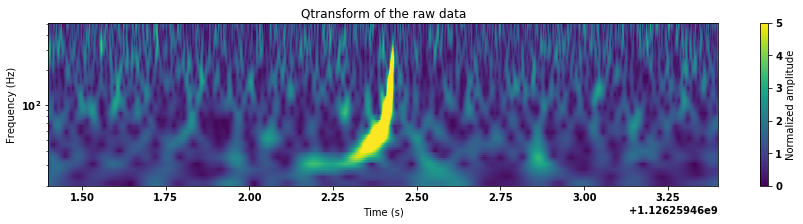

In [9]:
#visualisation of the signal first:

whitened = (strainF/psd**0.5).to_timeseries()
zoom = whitened.time_slice(merger.time - 2, merger.time + 2)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange = (20,512),
                             qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 1, merger.time + 1)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

Text(0,0.5,'Normalized amplitude')

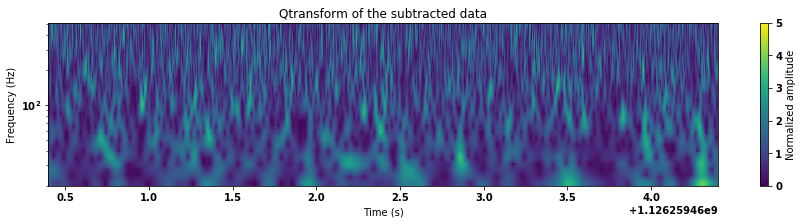

In [10]:
#subtraction of the signal
from pycbc.filter import sigma

dt = tmax - strainF.start_time
inj = hmax.cyclic_time_shift(dt)

#scaling of the template 
inj /= sigma(hmax, psd = psd, low_frequency_cutoff = 20.)
inj *= maxsnr

#subtraction
subF = strainF - inj

#whiten
subT_white = (subF/psd**0.5).to_timeseries()
zoom = subT_white.time_slice(merger.time - 2, merger.time + 2)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 2, merger.time + 2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [11]:
#the final best fit template for the event:
from pycbc.waveform import get_td_waveform

#freq
hp_f, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = 40.3, 
                         mass2 = 32.3, distance = 440, f_lower = 20., 
                                delta_f = strainF.delta_f)
hp_f.resize(len(strainF))
hp_f.start_time = strainF.start_time

#time
hp_t, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 40.3, 
                         mass2 = 32.3, distance = 440, f_lower = 20., 
                         delta_t = strain.delta_t)
hp_t.resize(len(strain))
hp_t.start_time = strain.start_time

We have found a model that enables to subtract the base signal out of the data. Now, we add a signal of the type hp_t in the signal (at 5 s) to see if it is still possible to retrieve one of both with the same type of analysis (and with the good template directly)

In [12]:
# making the signal with the injection at 5 sec
time_shifts = np.arange(5, 20, 0.01)

model_inj = None
max_amp_inj, time_inj, time_dif = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 40.3, 
                              mass2 = 32.3, distance = 440, f_lower = 20.,
                              delta_t = strain.delta_t)
    hpInj.resize(len(strain))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strain.start_time
    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_ev = hpInj.sample_times[ind]
    time_diff = time_ev - merger.time
    if (abs(time_diff - 5) < 0.01):
        model_inj = hpInj
        max_amp_inj, time_inj, time_dif_inj = max_amp, time_ev, time_diff


In [13]:
print(model_inj)
print(time_dif_inj)

[-7.70482183e-28  7.70426247e-28 -7.70370306e-28 ...  7.70650002e-28
 -7.70594064e-28  7.70538122e-28]
5.008447170257568


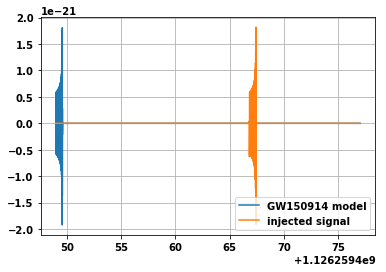

In [14]:
#representation of the comparison of the template and the signal
plt.plot(hp_t.sample_times, hp_t, label = 'GW150914 model')
plt.plot(model_inj.sample_times, model_inj, label='injected signal')
plt.grid()
plt.legend(loc='best')

In [15]:
#infos about the injection
print("Max amplitude: ", max_amp_inj)
print("time of the merger for the injection: ", time_inj)
print("Time gap between merger and injection: ", time_dif_inj)

('Max amplitude: ', 1.8173232814438908e-21)
('time of the merger for the injection: ', 1126259467.4084473)
('Time gap between merger and injection: ', 5.008447170257568)


In [16]:
#now we add the injection in the strain 

sig = strain + model_inj

sigF = sig.to_frequencyseries()

p = sig.psd(2)
p = interpolate(p, sig.delta_f)
psd = inverse_spectrum_truncation(p, 2*sig.sample_rate, 
                                 low_frequency_cutoff = 20.)

Text(0,0.5,'Normalized amplitude')

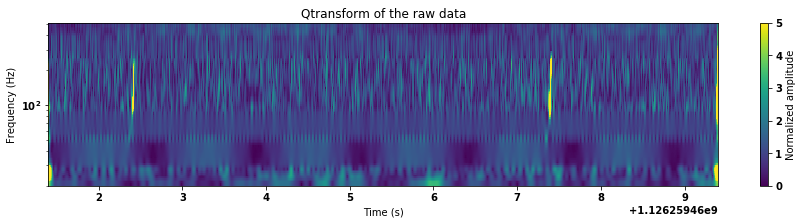

In [17]:
# qtransform of the data to see what it looks like

zoom = sig.time_slice(merger.time - 1, merger.time + 7)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange = (20,512),
                             qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 1, merger.time + 7)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

We see that the two injections are well present. We can now try to detect one of both

In [18]:
import numpy as np

mass1 = np.arange(32.5, 40.4, 0.1)
mass2 = np.arange(29.7, 32.4, 0.1)

hmax = None
maxsnr, m1max, m2max, tmax = 0, 0, 0, 0

snrs = [[] for i in range(len(mass1))]
max_snrs = [[] for i in range(len(mass1))]
times_max = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = strainF.delta_f)
        hp.resize(len(sigF))
        
        snr = matched_filter(hp, sigF, psd = psd, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 10, merger.time + 10)
        snrs[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrs[i].append(snrp)
        time = snr.sample_times[idx]
        times_max[i].append(time)
        
        # Keep track of the max snr
        
        if snrp > maxsnr:
            tmax, hmax, m1max, m2max, maxsnr = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1max, m2max, tmax, maxsnr))
print(time_inj)

mass 1 1/79
Done
mass 1 2/79
Done
mass 1 3/79
Done
mass 1 4/79
Done
mass 1 5/79
Done
mass 1 6/79
Done
mass 1 7/79
Done
mass 1 8/79
Done
mass 1 9/79
Done
mass 1 10/79
Done
mass 1 11/79
Done
mass 1 12/79
Done
mass 1 13/79
Done
mass 1 14/79
Done
mass 1 15/79
Done
mass 1 16/79
Done
mass 1 17/79
Done
mass 1 18/79
Done
mass 1 19/79
Done
mass 1 20/79
Done
mass 1 21/79
Done
mass 1 22/79
Done
mass 1 23/79
Done
mass 1 24/79
Done
mass 1 25/79
Done
mass 1 26/79
Done
mass 1 27/79
Done
mass 1 28/79
Done
mass 1 29/79
Done
mass 1 30/79
Done
mass 1 31/79
Done
mass 1 32/79
Done
mass 1 33/79
Done
mass 1 34/79
Done
mass 1 35/79
Done
mass 1 36/79
Done
mass 1 37/79
Done
mass 1 38/79
Done
mass 1 39/79
Done
mass 1 40/79
Done
mass 1 41/79
Done
mass 1 42/79
Done
mass 1 43/79
Done
mass 1 44/79
Done
mass 1 45/79
Done
mass 1 46/79
Done
mass 1 47/79
Done
mass 1 48/79
Done
mass 1 49/79
Done
mass 1 50/79
Done
mass 1 51/79
Done
mass 1 52/79
Done
mass 1 53/79
Done
mass 1 54/79
Done
mass 1 55/79
Done
mass 1 56/79
Done
m

Text(0,0.5,'Normalized amplitude')

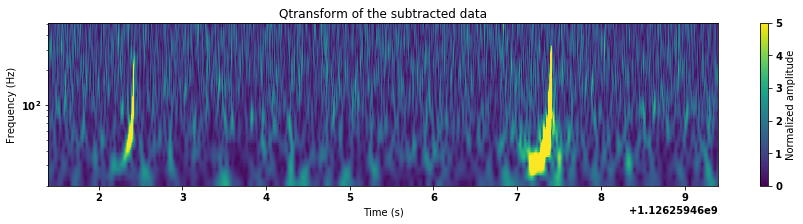

In [19]:
#subtraction of the signal to see if it works

dt = tmax - sigF.start_time
inj = hmax.cyclic_time_shift(dt)

#scaling of the template 
inj /= sigma(hmax, psd = psd, low_frequency_cutoff = 20.)
inj *= maxsnr

#subtraction
subF = sigF - inj

#whiten
subT_white = (subF/psd**0.5).to_timeseries()
zoom = subT_white.time_slice(merger.time - 1, merger.time + 7)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 1, merger.time + 7)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

Because we can see that the event is not well subtracted in this case, we can do a best fit procedure in the time domain, as as has been done in the complete analysis, where the result found by the matched_filter is used as the starting parameters for the best fit.

In [20]:
f_low = 20.
f_upper = 1024.

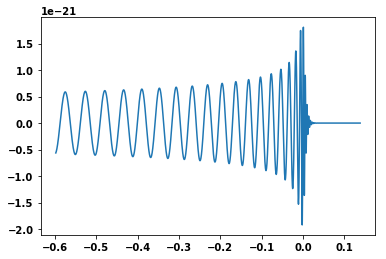

In [21]:
#starting model that wil be adjusted:

hp_st, hf_st = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1max,
                              mass2 = m2max, distance = 440, delta_t = sig.delta_t,
                              f_lower = f_low)
plt.plot(hp_st.sample_times, hp_st)

Text(0.5,1,'Whitened data of GW150914 with the signal injected at 5 s')

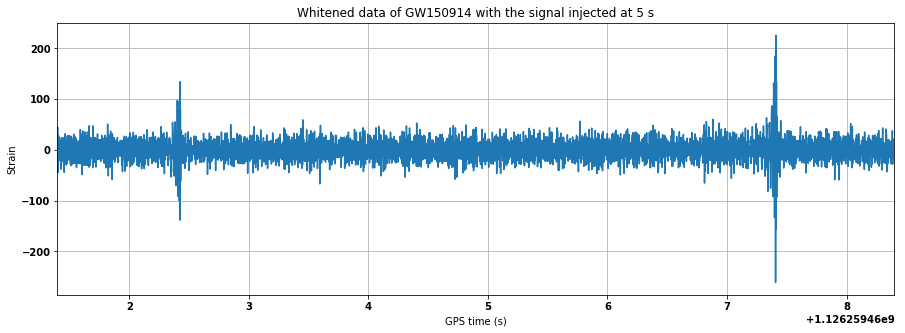

In [22]:
#whitening of the data
white_sig =  (sigF/psd**0.5).to_timeseries()
white_sig = white_sig.highpass_fir(30., 512).lowpass_fir(300, 512)
white_sig = white_sig.time_slice(merger.time - 5, merger.time + 10)

plt.figure(figsize = [15, 5])
plt.plot(white_sig.sample_times, white_sig)
plt.xlim(merger.time - 1, merger.time + 6)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.grid()
plt.title("Whitened data of GW150914 with the signal injected at 5 s")

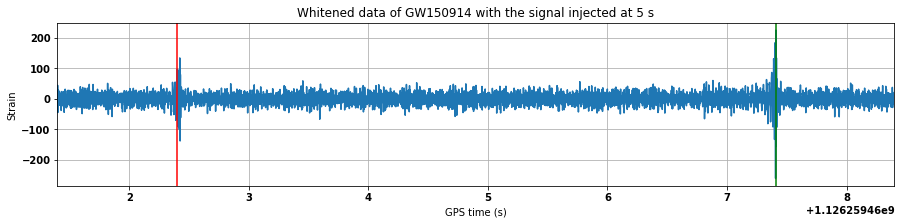

In [23]:
#test to check that the two peak are indeed the two awaited events 

plt.figure(figsize = [15, 3])
plt.plot(white_sig.sample_times, white_sig)
plt.xlim(merger.time - 1, merger.time + 6)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.title("Whitened data of GW150914 with the signal injected at 5 s")
plt.axvline(merger.time, color = 'red')
plt.axvline(merger.time + time_dif_inj, color = 'green')
plt.grid()

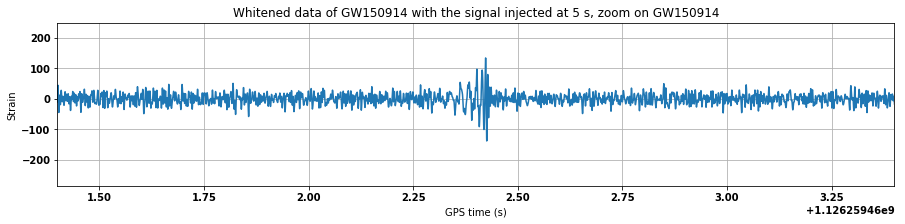

In [24]:
#zoom on the merger
plt.figure(figsize = [15, 3])
plt.plot(white_sig.sample_times, white_sig)
plt.xlim(merger.time - 1, merger.time + 1)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.title("Whitened data of GW150914 with the signal injected at 5 s, zoom on GW150914")
plt.grid()

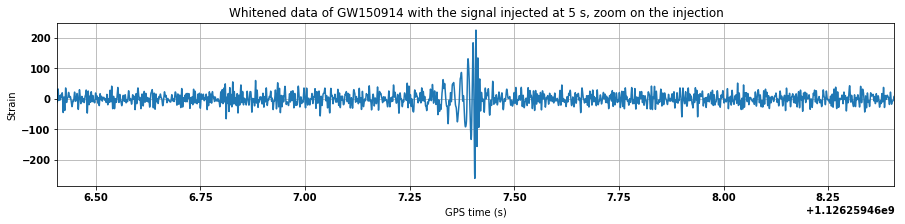

In [25]:
#zoom on the merger
plt.figure(figsize = [15, 3])
plt.plot(white_sig.sample_times, white_sig)
plt.xlim(merger.time + time_dif_inj - 1, merger.time + time_dif_inj + 1)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.title("Whitened data of GW150914 with the signal injected at 5 s, zoom on the injection")
plt.grid()

We observe that tha two events are well separated and that both can directly be indendtifies as a GW event on their own. This could mean that the best fit procedure, once more or less centered thanks to the matched_filter could enable to find well one of the signal and enable to subract it before looking for the next one.

In [26]:
def gen_template(theta, delta_t = sig.delta_t, 
                 duration = sig.duration, start_time = sig.start_time,
                 f_lower = f_low):
    
    #unpack values used to adapt the template
    m1, m2, dist, time = theta
    
    #make the templayte with the values provided and adjust it to data
    hp, hc = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = m1,
                            mass2 = m2, distance = dist, 
                             delta_t = delta_t, f_lower = f_low)
    
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - sig.start_time)
    hp.start_time = sig.start_time
    
    return hp

In [27]:
from pycbc.filter import sigma, matched_filter
from pycbc.filter import get_cutoff_indices as get_ind
def loglikelihood(theta, df = sigF, f_lower = f_low, f_upper = f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t = df.delta_t, 
                            f_lower = f_low)
    hf = template.to_frequencyseries()
    
    kmin, kmax = get_ind(f_lower, f_upper, df.delta_f,
                                          (N-1)*2)
    
    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj() * hf[kmin:kmax]).real()/psd[kmin:kmax])
    dh = sum (4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
    
    logl = -0.5*(hh - 2.0*dh)
    
    return logl

In [28]:


def whiten_trim_template(template, psd = psd):
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd**0.5).to_timeseries()
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 10)
    
    return white_temp

def plot_white_strain(strain, template, zoom):
    white_data = (sigF/psd**0.5).to_timeseries()
    
    tapered = template.highpass_fir(30, 512, remove_corrupted = False)
    white_temp = (tapered.to_frequencyseries()/psd **0.5).to_timeseries()
    
    white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
    white_temp = white_temp.highpass_fir(30,512).lowpass_fir(300,512)
    
    white_data = white_data.time_slice(merger.time - 5, merger.time + 10)
    white_temp = white_temp.time_slice(merger.time - 5, merger.time + 10)
    
    plt.figure(figsize = [15 , 3])
    plt.plot(white_data.sample_times, white_data, label = 'data')
    plt.plot(white_temp.sample_times, white_temp, label = 'template')
    plt.legend()
    plt.grid()
    plt.title("Superposition data and template")
    plt.ylabel("Strain")
    plt.xlabel("GPS time (s)")
    
    if zoom is True:
        plt.xlim(merger.time - 0.5, merger.time + 5.5)
    if zoom is False:
        plt.xlim(merger.time - 5, merger.time + 10)
        

-853.3312971586449


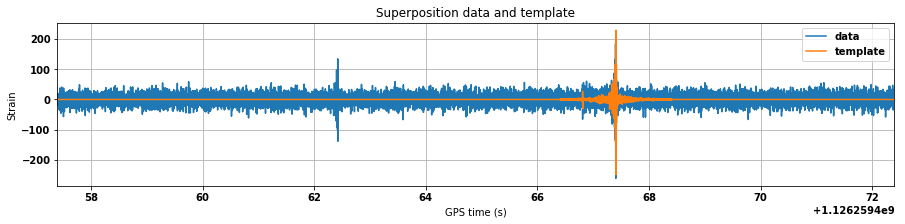

In [29]:
#initialisation of the values to those found with the matched filtering

theta0 = [m1max, m2max, 440, tmax]

temp0 = gen_template(theta0)
plot_white_strain(sig, temp0, False)

print(loglikelihood(theta0))

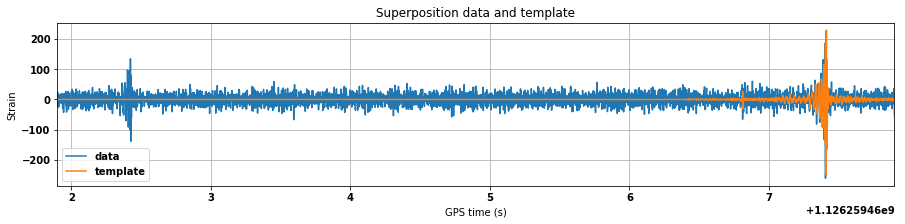

In [32]:
#plot zoomed version of the theta0

plot_white_strain(sig, temp0, True)

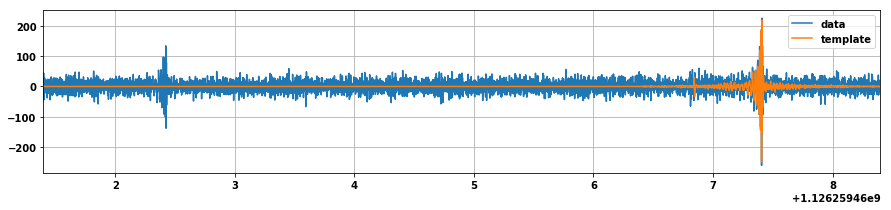

Steps 	 log(likelihood)
8 	 572.927


In [31]:
#best fit to adapt the found parameters to the signal
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize = [15, 3])
Neval = 1

white_temp = whiten_trim_template(gen_template(theta0))

plt.plot(white_sig.sample_times, white_sig, label = 'data')
line, = plt.plot(white_temp.sample_times, white_temp, label = 'template')

plt.xlim(merger.time - 1, merger.time + 6)
plt.grid()
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    temp = gen_template(thetai)
    white_temp = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_temp)
    
    clear_output(wait = True)
    display(fig)
    print("Steps \t log(likelihood)")
    print("%i \t %.3f" %(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta : -loglikelihood(theta), theta0, 
              callback = callback, method = 'powell')
plt.close()

[4.28591597e+01 3.23030747e+01 4.53556960e+02 1.12625947e+09]


Text(0.5,1,'Whitened signal with best fit template superposed')

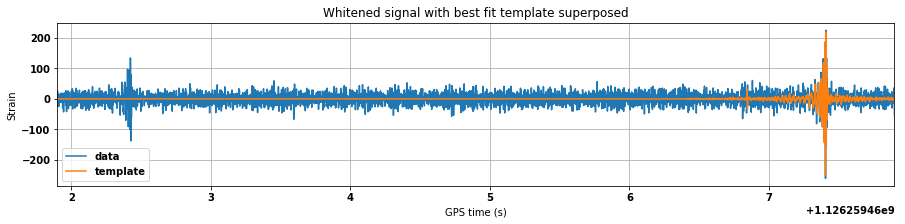

In [33]:
params = res.x
print(params)
best_fit_temp = gen_template(params)
plot_white_strain(sig, best_fit_temp, True)
plt.title("Whitened signal with best fit template superposed")

(1126259467.2084472, 1126259467.6084473)

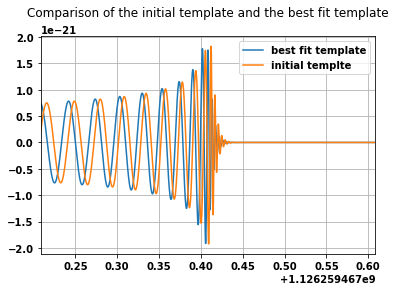

In [34]:
#comparion of the best_fit_temp and the initial template
plt.plot(best_fit_temp.sample_times, best_fit_temp, label = 'best fit template')
plt.plot(temp0.sample_times, temp0, label = 'initial templte')
plt.title("Comparison of the initial template and the best fit template", 
         pad = 20)
plt.grid()
plt.legend(loc='best')
plt.xlim(merger.time + time_dif_inj - 0.2, merger.time + time_dif_inj + 0.2)

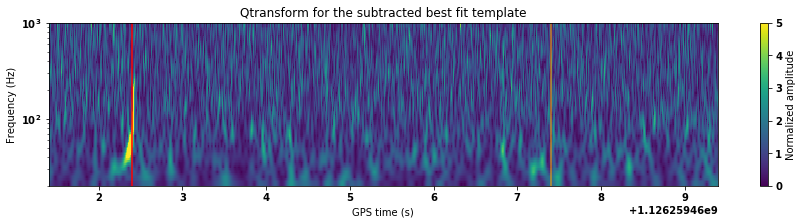

In [36]:
#try to subtract the best fit template to see if it works

subtracted = sig - best_fit_temp

t, f, p = subtracted.whiten(4,4).qtransform(.001, logfsteps = 100,
                                           qrange = (8,8), 
                                            frange = (20, 1000))
plt.figure(figsize = [15,3])
plt.title("Qtransform for the subtracted best fit template")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.xlim(merger.time - 1, merger.time + 7)
plt.ylim(0, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.axvline(merger.time, color = 'red')
plt.axvline(merger.time + time_dif_inj, alpha = 0.7, color = 'orange')

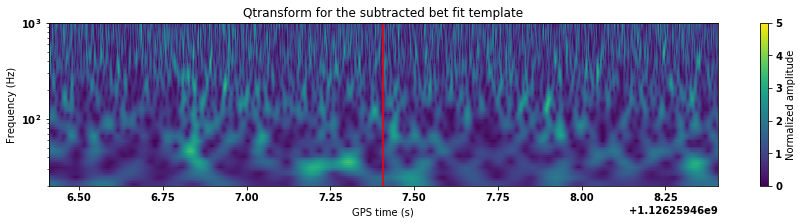

In [37]:
# zoom on the time of the injecton
zoom_inj = subtracted.whiten(4,4).time_slice(merger.time + time_dif_inj - 1, merger.time + time_dif_inj + 1)
t, f, p = zoom_inj.qtransform(.001, logfsteps = 100,
                                        qrange = (8,8), 
                                        frange = (20, 1000))
plt.figure(figsize = [15,3])
plt.title("Qtransform for the subtracted bet fit template")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.ylim(merger.time + time_dif_inj - 1, merger.time + time_dif_inj + 1)
plt.ylim(0, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude") 
plt.axvline(time_inj, color = 'red')

The subtraction works after the best fit has been done. Maybe we can check if there is a more complete way to do it, with an improvement of the fitting. It can be argued that the lowest frequency part of the signal is still slightly present. However, I think that the importance of the signal has been decreased enough in order to find the other signal with the mass method.

Text(0.5,1,'PSD of the subtracted data')

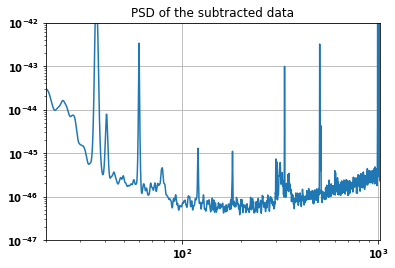

In [38]:
#psd of the subtracted data
p = subtracted.psd(2)
p = interpolate(p, subtracted.delta_f)
psd_s = inverse_spectrum_truncation(p, 2*subtracted.sample_rate, 
                                  low_frequency_cutoff = 15.,
                                  trunc_method = 'hann')

#plot it
plt.loglog(psd_s.sample_frequencies, psd_s)
plt.grid()
plt.xlim(20,1024)
plt.ylim(1e-47, 1e-42)
plt.title("PSD of the subtracted data")

(20, 1024)

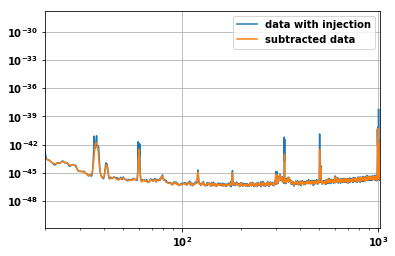

In [39]:
#out of curiosity, compare the PSD of the subtracted data and that 
#with injection

plt.loglog(psd.sample_frequencies, psd, label = 'data with injection')
plt.loglog(psd_s.sample_frequencies, psd_s, label = 'subtracted data')
plt.legend(loc= 'best')
plt.grid()
plt.xlim(20,1024)
#plt.ylim(1e-47, 1e-42)

This graph is in agreement with what has already been done in the master thesis. There is indeed a loss of power for some peaks due to the event. However, it seems to be even clearer here

In [40]:
#subtracted signal in the frequency domain
subF = subtracted.to_frequencyseries()

In [41]:
#matched filtering for the event

mass1 = np.arange(32.5, 40.4, 0.1)
mass2 = np.arange(29.1, 32.4, 0.1)

hmaxS = None
maxsnrS, m1maxS, m2maxS, tmaxS = 0, 0, 0, 0

snrsS = [[] for i in range(len(mass1))]
max_snrsS = [[] for i in range(len(mass1))]
time_maxS = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass 1: %i/%i" %(i+1,len(mass1)))
    for m2 in mass2:
        #template generation
        hp, _ = get_fd_waveform(approximant = 'IMRPhenomD', mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20.,
                               delta_f = subF.delta_f)
        hp.resize(len(subF))
        
        #matched filtering
        snr = matched_filter(hp, subF, psd = psd_s, 
                             low_frequency_cutoff = 20.)
        snr = snr.time_slice(merger.time - 10, merger.time + 10)
        snrsS[i].append(snr)
        ind = abs(snr).numpy().argmax()
        snrp = abs(snr[ind])
        max_snrsS[i].append(snrp)
        time = snr.sample_times[ind]
        time_maxS[i].append(time)
        
        #keep track of max snr
        
        if snrp > maxsnrS:
            tmaxS, hmaxS, m1maxS, m2maxS, maxsnrS = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.2f and m2 = %.2f at time %.7f with a value of %.7f" %(m1maxS, m2maxS, tmaxS, maxsnrS))

Mass 1: 1/79
Done
Mass 1: 2/79
Done
Mass 1: 3/79
Done
Mass 1: 4/79
Done
Mass 1: 5/79
Done
Mass 1: 6/79
Done
Mass 1: 7/79
Done
Mass 1: 8/79
Done
Mass 1: 9/79
Done
Mass 1: 10/79
Done
Mass 1: 11/79
Done
Mass 1: 12/79
Done
Mass 1: 13/79
Done
Mass 1: 14/79
Done
Mass 1: 15/79
Done
Mass 1: 16/79
Done
Mass 1: 17/79
Done
Mass 1: 18/79
Done
Mass 1: 19/79
Done
Mass 1: 20/79
Done
Mass 1: 21/79
Done
Mass 1: 22/79
Done
Mass 1: 23/79
Done
Mass 1: 24/79
Done
Mass 1: 25/79
Done
Mass 1: 26/79
Done
Mass 1: 27/79
Done
Mass 1: 28/79
Done
Mass 1: 29/79
Done
Mass 1: 30/79
Done
Mass 1: 31/79
Done
Mass 1: 32/79
Done
Mass 1: 33/79
Done
Mass 1: 34/79
Done
Mass 1: 35/79
Done
Mass 1: 36/79
Done
Mass 1: 37/79
Done
Mass 1: 38/79
Done
Mass 1: 39/79
Done
Mass 1: 40/79
Done
Mass 1: 41/79
Done
Mass 1: 42/79
Done
Mass 1: 43/79
Done
Mass 1: 44/79
Done
Mass 1: 45/79
Done
Mass 1: 46/79
Done
Mass 1: 47/79
Done
Mass 1: 48/79
Done
Mass 1: 49/79
Done
Mass 1: 50/79
Done
Mass 1: 51/79
Done
Mass 1: 52/79
Done
Mass 1: 53/79
Done
Ma

In [42]:
print(merger.time)

1126259462.4


Text(0,0.5,'Normalized amplitude')

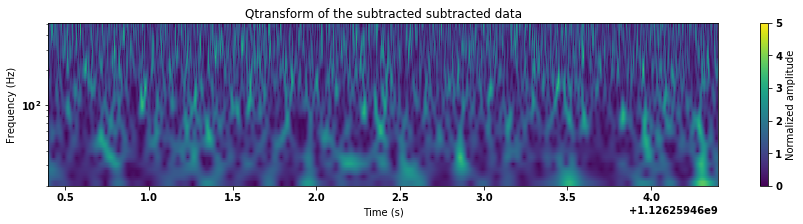

In [43]:
#see if the data can directly be subtracted out of the data,
#else fitting


dt = tmaxS - subF.start_time
inj = hmaxS.cyclic_time_shift(dt)

#scale tempplate

inj /= sigma(hmaxS, psd = psd_s, low_frequency_cutoff = 20.)
inj *= maxsnrS

subsubF = subF - inj

#whiten 

subsub_white = (subsubF/psd_s**0.5).to_timeseries()
zoom = subsub_white.time_slice(merger.time -2, merger.time + 2)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,512),
                         qrange = (8,8))

plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 2, merger.time + 2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

We see that with this method, the two signal can be subtracted the one after the other. Now, we can try to do the same in the case of other signal, especially in the case of overlapping signals.